# Question 1

In [134]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


To import the data, we used a regex that used 2 or more spaces as a delimiter. This was able to capture the county and state in one column and took care of the long spacing between county and the first column.

In [135]:
df = pd.read_csv('http://users.stat.ufl.edu/~winner/data/clinton1.dat', \
                names=['CountyName', 'percentVoting', \
                      'MedianAge', 'MeanSavings', 'PerCapitalIncome',\
                      'PercentInPoverty', 'PercentVeterans', \
                      'PercentFemale', 'PopulationDensity', \
                      'PercentInNursingHomes', 'CrimeIndex'], \
                sep='\s+\s+', engine='python', header=None)

df = df.set_index('CountyName')
df[:10]

,percentVoting,MedianAge,MeanSavings,PerCapitalIncome,PercentInPoverty,PercentVeterans,PercentFemale,PopulationDensity,PercentInNursingHomes,CrimeIndex
CountyName,,,,,,,,,,
"Autauga, AL",30.92,31.7,57623,15768,15.2,10.74,51.41,60.4,2.36,457
"Baldwin, AL",26.24,35.5,84935,16954,13.6,9.73,51.34,66.5,5.40,282
"Barbour, AL",46.36,32.8,83656,15532,25.0,8.82,53.03,28.8,7.02,47
"Blount, AL",32.92,34.5,61249,14820,15.0,9.67,51.15,62.4,2.36,185
"Bullock, AL",67.67,31.7,75725,11120,33.0,7.08,50.76,17.6,2.91,141
"Butler, AL",47.43,33.5,75887,12015,27.1,9.48,53.25,28.1,7.98,266
"Calhoun, AL",38.44,32.7,76073,15162,18.0,11.95,51.66,190.8,4.81,560
"Chambers, AL",45.36,34.8,40498,13887,18.8,10.52,52.77,62.1,6.15,218
"Cherokee, AL",53.61,36.3,56386,13936,15.4,9.29,50.82,35.8,5.61,51


# Question 2

We wrote a loop to product the long regression string used for pasty. This would encapsulate all of the necessary columns. We then used statsmodels to create a regression based of the dmatrices.

In [136]:
# Create a dmatrices
# Build a string for the regression
regres_string = 'percentVoting ~ '
count = 2
ignore = ['percentVoting']
for col in df.columns.values:
    if col in ignore:
        continue
    regres_string += col
    if count != len(df.columns.values):
        regres_string += ' + '
    count += 1

# Get the datamatrices
y, X = dmatrices(regres_string, data=df, return_type='dataframe')

# Create the model and fit it
model = sm.OLS(y, X)
result = model.fit()
print result.pvalues.drop('Intercept').sort_values()[:2]

PercentInPoverty    9.526970e-100
PercentFemale        4.425751e-23
dtype: float64


# Question 3

We actually used the same string builder as above with some slight modification to make it more extendible. We loop through the regressors and build out the regression string and leave out the last regressors's "+".

In [137]:
# Create a function to build regression formula
def formula(regressors):
    regres_string = 'percentVoting ~ '
    count = 1
    
    # loop through the regressor
    for col in regressors:
        regres_string += col
        
        if count != len(regressors):
            regres_string += ' + '
        count += 1
    return regres_string

formula_test = formula(['age', 'savings'])
print formula_test

percentVoting ~ age + savings


# Question 4

We took the regression approach we used in Question 2 and converted it into a function. We get the formula for the regression string by calling the previous function and then use statsmodels to build the regression model.

In [138]:
def rsquared(regressors):
    '''Takes a list of regressors and returns the corresponding rsquared'''

    # Get the formula 
    equation = formula(regressors)
    
    # Get the design matrices for the regression
    y, X = dmatrices(equation, data=df, return_type='dataframe')
    
    # Create a model for the regression
    model = sm.OLS(y, X)
    result = model.fit()
    
    return result.rsquared
    
# Create a list of regressors
regressors = df.columns.values[1:5]

# Get sample data
result = rsquared(regressors)
print result

0.271177655492


# Question 5

We created a loop that checks if the regressor is already in the all_regressor_list. We then get the rsqaured for the current mix of regressor plus a new option by calling Question 4s "rsqaure" function. We then store the highest rsquare and regressor's name in a tuple and return the tuple. 

In [139]:
def best_next_regressor(current_regressor_list, all_regressor_list):
    '''Take in a regressor list and finds the highest rsquared when 
    combined with another regressor'''
    
    # A tuples to hold the highest rquareds and the regressor
    rsquareds = (-1, "")
    
    # Loop through every regressor to create the best combination
    for regressor in all_regressor_list:
        
        # Check if the regressor is not in the current list
        if regressor not in current_regressor_list:
            
            # Create a formula for the regressors
            current_regressor_mix = current_regressor_list[:]
            current_regressor_mix.append(regressor)
    
            # Get the rsquared
            current_rsquared = rsquared(current_regressor_mix)

            # Add the rsquared to the list
            rsquared_regressor = (current_rsquared, regressor)
            
            # Check if the rsquared is bigger than the current one
            if rsquared_regressor > rsquareds[0]:
                rsquareds = (rsquared_regressor, regressor)
    
    return rsquareds
    
# Current list 
current_regressors = ['MeanSavings']
best_next_regressor(current_regressors, df.columns.values[1:])

((0.25237620362101276, 'PercentInPoverty'), 'PercentInPoverty')

# Question 6

We chose to store the results of each regressors rsquared in a list of tuples consisting of the rsquared value and the regressors name. We then created a custom sorting function to put them in descending order. We then create a tuple of the rsquareds list and named regressors list and return the corresponding amount in num_regressors.

In [140]:
def sort_first(t):
    '''Takes in a tuples and returns the first element'''
    return t[0]

def best_regressors(num_regressors, all_regressors_list):
    '''Returns the k number of best regressors'''
    
    # Create a list of tuples of the rsquared and the regressor name
    named_rsquareds = []
    
    # Loop through each regressor
    for regressor in all_regressors_list:
        
        # Get the rsquared
        current_rsquared = rsquared([regressor])
        named_rsquareds.append((current_rsquared, regressor))
        
    # Sort named_rquareds
    named_rsquareds.sort(key=sort_first, reverse=True)
    
    # Return a tuple containing a list of rsquares and the names
    return_rs = []
    return_names =[]
    for r in named_rsquareds:
        return_rs.append(r[0])
        return_names.append(r[1])
    
    # Combine the list and return a tuple
    return_tuple = (return_rs, return_names)
    return return_tuple[:num_regressors]    

# Question 7

We used the function in Question 6, and passed in the all the possible regressors from the DataFrame.

In [141]:
# Get a list of the best regressors
best_regressors = best_regressors(len(df.columns.values[1:]), df.columns.values[1:])
print best_regressors

([0.25103851961631984, 0.072252743133890851, 0.050458771395530011, 0.034041750136227011, 0.019656116235418519, 0.014552732663332124, 0.011317144443458882, 0.0087569115413174137, 0.0033799834005024953], ['PercentInPoverty', 'PercentFemale', 'PerCapitalIncome', 'PopulationDensity', 'MeanSavings', 'CrimeIndex', 'PercentVeterans', 'PercentInNursingHomes', 'MedianAge'])


# Question 8

Our approach was to create a rolling total of the sum of the regressors. We then plotted this against the number of regressors in that rolling total. 

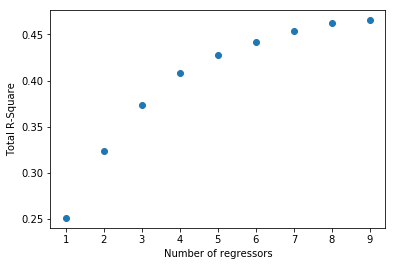

In [142]:
# Create a list of increasing adding r-squareds
rolling_total = [best_regressors[0][0]]
num_regressors = [x + 1 for x in range(len(best_regressors[0]))]
for i, r2 in enumerate(best_regressors[0][1:]):
    
    # Get the previous total for the combined r^2s
    previous_total = rolling_total[i]
    
    # Add the next r^2 to the next elements total
    next_total = previous_total + r2
    
    # Add the next rolling total
    rolling_total.append(next_total)
    
plot(num_regressors, rolling_total, marker='o', linestyle='None')
xlabel('Number of regressors')
ylabel('Total R-Square')
show()
    

# Question 9

We created a mask for the target column for at least 40% voting and then applied that mask to set the True values in the boolean mast to 1.0. This indicated that at least 40% of the county voted for Bill Clinton. 

In [143]:
# Create a new target column
df['target'] = 0.0

# Create a mask with rows that at least 40% percentVoting
mask = (df['percentVoting'] >= 40)
df['target'][mask] = 1.0

print df['target'].value_counts()

0.0    1469
1.0    1235
Name: target, dtype: int64


C:\Users\tracetschida\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Question 10

We created dmatrices without the intercepts based on poverty percentage and population density. We then used the scikit learn function to create training and testing data.

In [144]:
# Split the data into test and train matrices
Y, X = dmatrices('target ~ 0 + PercentInPoverty + PopulationDensity',
                df, return_type='dataframe')
y = Y['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                                    random_state=1)


# Question 11

We created a list of nearest neighbors amounts and iterate through that list changing the number of neighors for the training data. We then trained the model and tested it on the testing data.

In [145]:
num_neighbors = [1,3,5,10,20,50,100,1000]

# Test for different number of nearest neighbors
for num in num_neighbors:
    
    # Create the model
    model = neighbors.KNeighborsClassifier(n_neighbors=num, weights='uniform',
                                          p=2)
    # Fit the classifier to the training data
    model.fit(X_train, y_train)
    
    # Make predictions based on the model for the training class
    prediction_on_training = model.predict(X_train)
    
    # Make prediction based on the model for the testing class
    prediction_on_testing = model.predict(X_test)
    
    # Print the results
    print 'Number of Neighbors: ' + str(num) + '\n\tTraining Accuracy: ' + \
    str(metrics.accuracy_score(y_train, prediction_on_training)) + \
    '\n\tTest Accuracy: ' +  \
    str(metrics.accuracy_score(y_test, prediction_on_testing))

Number of Neighbors: 1
	Training Accuracy: 0.997885835095
	Test Accuracy: 0.600985221675
Number of Neighbors: 3
	Training Accuracy: 0.788054968288
	Test Accuracy: 0.635467980296
Number of Neighbors: 5
	Training Accuracy: 0.748414376321
	Test Accuracy: 0.630541871921
Number of Neighbors: 10
	Training Accuracy: 0.720401691332
	Test Accuracy: 0.646551724138
Number of Neighbors: 20
	Training Accuracy: 0.690274841438
	Test Accuracy: 0.658866995074
Number of Neighbors: 50
	Training Accuracy: 0.683932346723
	Test Accuracy: 0.662561576355
Number of Neighbors: 100
	Training Accuracy: 0.677589852008
	Test Accuracy: 0.663793103448
Number of Neighbors: 1000
	Training Accuracy: 0.567124735729
	Test Accuracy: 0.576354679803


# Question 12

It looks like more dense higher poverty counties voted for Bill Clinton. This indicated that large urban counties, probably with a large metropolitan city voted for Clinton. These larger cities typically have higher rates of poverty and lean left (Democratic)

Text(0,0.5,u'Percent in Poverty')

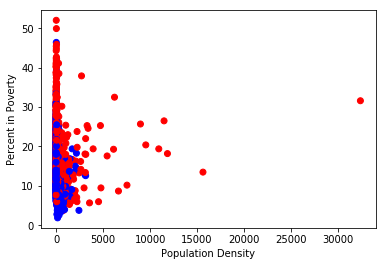

In [149]:
# Create a scatter plot of Population Density vs Poverty 
# Color by the target classification
sc = scatter(df['PopulationDensity'], df['PercentInPoverty'], c=df['target'], cmap='bwr')
xlabel('Population Density')
ylabel('Percent in Poverty')